In [57]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


from process import *
import mod

In [89]:
outputs = []
for res in [(1280, 720), (960, 540), (640, 360)]:
    for video in ['large_slow', 'large_fast', 'small_slow', 'small_fast']:
        output = mod.run(
            yolov5_model='yolov5n',
            img_width=res[0],
            img_height=res[1],
            fps=5,
            frame_cap=250,
            conf=0.6,
            video_path='../samples/testing/videos/',
            video_source=video,
            out_path=''
        )
        output['video'] = video
        output['x_res'] = res[0]
        output['y_res'] = res[1]
        outputs.append(output)

outputs = pd.concat(outputs)


Using cache found in C:\Users\adamf/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-6-26 Python-3.9.13 torch-2.0.1+cpu CPU

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 
Using cache found in C:\Users\adamf/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-6-26 Python-3.9.13 torch-2.0.1+cpu CPU



save failed
frames: 250
runtime (inference): 13.30772590637207
average time per frame: 0.05323090362548828
confidence: 0.6


Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 
Using cache found in C:\Users\adamf/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-6-26 Python-3.9.13 torch-2.0.1+cpu CPU

Fusing layers... 


save failed
frames: 250
runtime (inference): 12.88828182220459
average time per frame: 0.05155312728881836
confidence: 0.6


YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 


save failed
frames: 250
runtime (inference): 12.927541732788086
average time per frame: 0.051710166931152345
confidence: 0.6


Using cache found in C:\Users\adamf/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-6-26 Python-3.9.13 torch-2.0.1+cpu CPU

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 
Using cache found in C:\Users\adamf/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-6-26 Python-3.9.13 torch-2.0.1+cpu CPU

Fusing layers... 


save failed
frames: 250
runtime (inference): 13.101629734039307
average time per frame: 0.05240651893615723
confidence: 0.6


YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 
Using cache found in C:\Users\adamf/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-6-26 Python-3.9.13 torch-2.0.1+cpu CPU



save failed
frames: 250
runtime (inference): 7.60878586769104
average time per frame: 0.03043514347076416
confidence: 0.6


Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 


save failed
frames: 250
runtime (inference): 8.163791418075562
average time per frame: 0.03265516567230225
confidence: 0.6


Using cache found in C:\Users\adamf/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-6-26 Python-3.9.13 torch-2.0.1+cpu CPU

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 
Using cache found in C:\Users\adamf/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-6-26 Python-3.9.13 torch-2.0.1+cpu CPU



save failed
frames: 250
runtime (inference): 7.774673700332642
average time per frame: 0.031098694801330568
confidence: 0.6


Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 
Using cache found in C:\Users\adamf/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-6-26 Python-3.9.13 torch-2.0.1+cpu CPU

Fusing layers... 


save failed
frames: 250
runtime (inference): 8.357574939727783
average time per frame: 0.03343029975891113
confidence: 0.6


YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 


save failed
frames: 250
runtime (inference): 4.277980089187622
average time per frame: 0.01711192035675049
confidence: 0.6


Using cache found in C:\Users\adamf/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-6-26 Python-3.9.13 torch-2.0.1+cpu CPU

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 
Using cache found in C:\Users\adamf/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-6-26 Python-3.9.13 torch-2.0.1+cpu CPU

Fusing layers... 


save failed
frames: 250
runtime (inference): 4.15090274810791
average time per frame: 0.01660361099243164
confidence: 0.6


YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 
Using cache found in C:\Users\adamf/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-6-26 Python-3.9.13 torch-2.0.1+cpu CPU



save failed
frames: 250
runtime (inference): 4.24094820022583
average time per frame: 0.01696379280090332
confidence: 0.6


Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 


save failed
frames: 250
runtime (inference): 5.1801581382751465
average time per frame: 0.020720632553100585
confidence: 0.6


In [91]:
outputs

,xcenter,ycenter,width,height,confidence,...,name,frame,video,x_res,y_res
0,261.000061,170.209900,59.874023,156.529312,0.763476,...,person,1,large_slow,1280,720
0,261.000061,170.209900,59.874023,156.529312,0.763476,...,person,2,large_slow,1280,720
0,261.000061,170.209900,59.874023,156.529312,0.763476,...,person,3,large_slow,1280,720
0,261.000061,170.209900,59.874023,156.529312,0.763476,...,person,4,large_slow,1280,720
0,267.735931,171.493683,57.094193,154.408813,0.654082,...,person,5,large_slow,1280,720
...,...,...,...,...,...,...,...,...,...,...,...
0,750.430786,393.873566,50.154541,37.585938,0.617641,...,car,246,small_fast,640,360
0,750.430786,393.873566,50.154541,37.585938,0.617641,...,car,247,small_fast,640,360
0,750.430786,393.873566,50.154541,37.585938,0.617641,...,car,248,small_fast,640,360
0,750.430786,393.873566,50.154541,37.585938,0.617641,...,car,249,small_fast,640,360


In [90]:
average_sizes = {}
for res in [(1280, 720), (960, 540), (640, 360)]:
    for video in ['large_slow', 'large_fast', 'small_slow', 'small_fast']:
    average_size = 0
    for row in outputs.loc[video].iterrows():
        average_size += (row[1][2] * row[1][3])
    average_size /= len(outputs.loc[video])
    print(average_size)
    average_sizes[video] = average_size

df = pd.DataFrame(average_sizes, index=[0]).transpose().reset_index()

KeyError: 'large_slow'

In [ ]:
df

,index,0
0,large_slow,12456.418118
1,large_fast,49207.867968
2,small_slow,2292.689543
3,small_fast,4709.189786


In [ ]:
df.columns

Index(['large_slow', 'large_fast', 'small_slow', 'small_fast'], dtype='object')

<Axes: xlabel='index'>

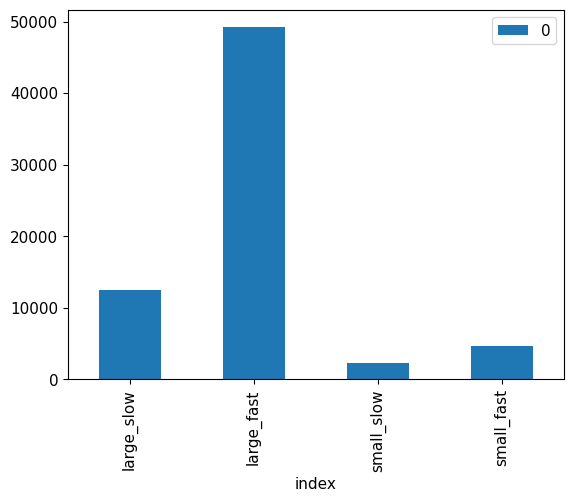

In [ ]:
df.plot.bar('index', 0)  
